<a href="https://colab.research.google.com/github/Pratham-04/CS711A-Fall-2020/blob/main/Project/Human_sim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pykalman
from pykalman import KalmanFilter
import numpy as np

mean_tm = [0.9558036282641713, 0.9475594560122231, 0.9360129609134596, 0.9011297059989769]
mean_tc = [3.266965089461436, 2.4665969002094967, 4.389718824029311, 2.6238772978107168]
mean_om = [1.3657745605840546, 1.6229340398234333, 1.5465626541860327, 1.6567636139937965]
mean_oc = [17.046294600024897, 12.120186059784064, 15.318890036378399, 13.805276234757352]


def makeReward(patchA, patchB, s1, s2):
    if s1 == s2:
        if s1 == 0:
            patchA = max(decay*decay*patchA + np.random.normal(0,1), 0)
            patchB = max(growth*patchB + np.random.normal(0,1), 0)
        else:
            patchA = max(growth*patchA + np.random.normal(0,1), 0)
            patchB = max(decay*decay*patchB + np.random.normal(0,1), 0)

    else:
          patchA = max(decay*patchA + np.random.normal(0,1), 0)
          patchB = max(decay*patchB + np.random.normal(0,1), 0)

    return patchA, patchB

rewards_fit = []

for u in range(1000):
    kfa1_fin = KalmanFilter(
        transition_matrices = mean_tm[0],
        transition_covariance = mean_tc[0],
        observation_matrices = mean_om[0],
        observation_covariance = mean_oc[0]
    )
    kfa2_fin = KalmanFilter(
        transition_matrices = mean_tm[1],
        transition_covariance = mean_tc[1],
        observation_matrices = mean_om[1],
        observation_covariance = mean_oc[1]
    )
    kfb1_fin = KalmanFilter(
        transition_matrices = mean_tm[2],
        transition_covariance = mean_tc[2],
        observation_matrices = mean_om[2],
        observation_covariance = mean_oc[2]
    )
    kfb2_fin = KalmanFilter(
        transition_matrices = mean_tm[3],
        transition_covariance = mean_tc[3],
        observation_matrices = mean_om[3],
        observation_covariance = mean_oc[3]
    )

    epsilon = 0.85
    patchA = 20
    patchB = 12
    decay = 0.95
    growth = 1.05
    chosen = 2*np.ones((30,2))
    reward = np.zeros((30,2))

    mean_a1 = 16*np.ones(30)
    cov_a1 = 25*np.ones(30)
    mean_b1 = 16*np.ones(30)
    cov_b1 = 25*np.ones(30)
    mean_a2 = 16*np.ones(30)
    cov_a2 = 25*np.ones(30)
    mean_b2 = 16*np.ones(30)
    cov_b2 = 25*np.ones(30)

    patchA1 = np.ma.zeros(30)
    patchB1 = np.ma.zeros(30)
    patchA2 = np.ma.zeros(30)
    patchB2 = np.ma.zeros(30)

    for i in range(30):

        print(u, i)

        if i > 0:
            mean_a1[i], cov_a1[i] = kfa1_fin.filter_update(mean_a1[i-1], cov_a1[i-1], patchA1[i-1])
            mean_a2[i], cov_a2[i] = kfa2_fin.filter_update(mean_a2[i-1], cov_a2[i-1], patchA2[i-1])
            mean_b1[i], cov_b1[i] = kfb1_fin.filter_update(mean_b1[i-1], cov_b1[i-1], patchB1[i-1])
            mean_b2[i], cov_b2[i] = kfb2_fin.filter_update(mean_b2[i-1], cov_b2[i-1], patchB2[i-1])

        p1 = np.random.uniform()
        if p1 < epsilon:
            chosen[i][0] = round(np.random.uniform())
        else:
            if mean_a1[i] > mean_b1[i]:
                chosen[i][0] = 0
            elif mean_a1[i] == mean_b1[i]:
                chosen[i][0] = round(np.random.uniform())
            else:
                chosen[i][0] = 1

        p2 = np.random.uniform()
        if p2 < epsilon:
            chosen[i][1] = round(np.random.uniform())
        else:
            if mean_a2[i] > mean_b2[i]:
                chosen[i][1] = 0
            elif mean_a2[i] == mean_b2[i]:
                chosen[i][1] = round(np.random.uniform())
            else:
                chosen[i][1] = 1

        s1 = chosen[i][0]
        s2 = chosen[i][1]

        if s1 == s2:
            if s1 == 0:
                patchA1[i] = patchA/2
                patchB1[i] = np.ma.masked
                patchA2[i] = patchA/2
                patchB2[i] = np.ma.masked
                reward[i][0] = patchA/2
                reward[i][1] = patchA/2
            else:
                patchA1[i] = np.ma.masked
                patchB1[i] = patchB/2
                patchA2[i] = np.ma.masked
                patchB2[i] = patchB/2
                reward[i][0] = patchB/2
                reward[i][1] = patchB/2
        else:
            if s1 == 0:
                patchA1[i] = patchA
                patchB1[i] = np.ma.masked
                patchA2[i] = np.ma.masked
                patchB2[i] = patchB
                reward[i][0] = patchA
                reward[i][1] = patchB
            else:
                patchA1[i] = np.ma.masked
                patchB1[i] = patchB
                patchA2[i] = patchA
                patchB2[i] = np.ma.masked
                reward[i][0] = patchB
                reward[i][1] = patchA
        patchA, patchB = makeReward(patchA, patchB, s1, s2)


    count1 = 0
    count2 = 0
    for i in range(30):
        count1 = count1 + reward[i][0]
        count2 = count2 + reward[i][1]
    rewards_fit.append(count1)
    rewards_fit.append(count2)







Streaming output truncated to the last 5000 lines.
833 10
833 11
833 12
833 13
833 14
833 15
833 16
833 17
833 18
833 19
833 20
833 21
833 22
833 23
833 24
833 25
833 26
833 27
833 28
833 29
834 0
834 1
834 2
834 3
834 4
834 5
834 6
834 7
834 8
834 9
834 10
834 11
834 12
834 13
834 14
834 15
834 16
834 17
834 18
834 19
834 20
834 21
834 22
834 23
834 24
834 25
834 26
834 27
834 28
834 29
835 0
835 1
835 2
835 3
835 4
835 5
835 6
835 7
835 8
835 9
835 10
835 11
835 12
835 13
835 14
835 15
835 16
835 17
835 18
835 19
835 20
835 21
835 22
835 23
835 24
835 25
835 26
835 27
835 28
835 29
836 0
836 1
836 2
836 3
836 4
836 5
836 6
836 7
836 8
836 9
836 10
836 11
836 12
836 13
836 14
836 15
836 16
836 17
836 18
836 19
836 20
836 21
836 22
836 23
836 24
836 25
836 26
836 27
836 28
836 29
837 0
837 1
837 2
837 3
837 4
837 5
837 6
837 7
837 8
837 9
837 10
837 11
837 12
837 13
837 14
837 15
837 16
837 17
837 18
837 19
837 20
837 21
837 22
837 23
837 24
837 25
837 26
837 27
837 28
837 29
838 0
838

In [ ]:
print(rewards_fit)
import statistics

print(statistics.mean(rewards_fit))
print(statistics.stdev(rewards_fit))

[251.4015594285904, 221.8585507590695, 280.859860820061, 293.1446263795018, 267.96887496374006, 258.5802493638769, 233.9324285723305, 211.0597016200992, 182.70799102145668, 199.38224453906608, 286.4366807423713, 287.8521311425835, 216.66716696907145, 192.82990069296875, 217.00027307118512, 150.32508529827916, 248.5802080965403, 273.591048073745, 193.12176703942575, 154.43230605911097, 163.2332253627973, 155.91584910565751, 259.8987909237058, 272.5660821818895, 227.11302174113345, 219.90908932213884, 249.08918940652805, 274.6578892327157, 170.23309085799994, 197.45676010924564, 248.98489971124783, 280.9250176203822, 173.22631181134648, 163.68145285902145, 178.48963289892527, 244.40049610635276, 162.32424135836135, 171.9250617667815, 240.97009586542077, 227.58499033731104, 198.58522647405735, 227.3360682208883, 173.10650014060894, 185.39253268105742, 261.60947426965123, 251.38546794918756, 295.55387032794994, 261.5302682875526, 199.14176849261509, 207.00234968290926, 213.62848144759357, 

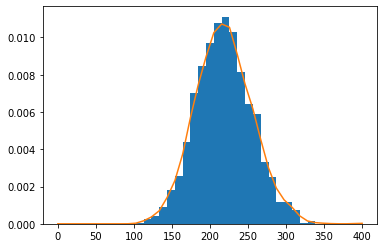

In [ ]:
import matplotlib.pyplot as plt
import scipy.stats as stats

density = stats.gaussian_kde(rewards_fit)
n,x,_ = plt.hist(rewards_fit, bins = np.linspace(0,400,40), density = True)
plt.plot(x, density(x))
plt.show()

# plt.hist(rewards_fit, bins = np.linspace(0,400,40))

In [ ]:
games = 